Import Julia packages

In [1]:
using DelimitedFiles
using DataFrames
using JuMP
using Ipopt
using Plots

Read "port1.txt" file and organize average return and standard deviation of the 31 assets which is the information of lines 2 to 32 in the text file.

In [2]:
df1 = readdlm("port1.txt", ' ')
df_returns = DataFrame(df1[2:32,2:3], :auto)
rename!(df_returns, ["avg_return", "std"])
df_returns[1:6,:]

,avg_return,std
,Any,Any
1,0.001309,0.043208
2,0.004177,0.040258
3,0.001487,0.041342
4,0.004515,0.044896
5,0.010865,0.069105
6,0.001759,0.053671


Read "port1.txt" file skipping the first 32 lines to get the correlation between assets as a data frame. Reshape the data frame in order to get $31^2 = 961$ combinations of assets $i$ and $j$ and the respective correlations, sorted by $i$ and $j$. The correlation in the $(i-1) * 31 + j$ line corresponds to the correlation of assests $i$ and $j$, useful information to write the objective function of the problem.

In [3]:
cor = readdlm("port1.txt", ' ', skipstart=32)
cor = cor[:,2:4]
df_cor1 = DataFrame(cor, :auto)
rename!(df_cor1, ["asset_i", "asset_j", "cor_ij"])
df_cor2 = df_cor1[!,[2,1,3]]
rename!(df_cor2, ["asset_i", "asset_j", "cor_ij"])
df_cor = unique(vcat(df_cor1, df_cor2))
sort!(df_cor, [:asset_i, :asset_j]);
df_cor[1:6,:]

,asset_i,asset_j,cor_ij
,Any,Any,Any
1,1,1,1.0
2,1,2,0.562289
3,1,3,0.746125
4,1,4,0.707857
5,1,5,0.336386
6,1,6,0.704836


Initialize a optimization model with Ipopt backend and make it silent.

In [4]:
model = Model(Ipopt.Optimizer)
set_silent(model)

Set the 31 variables of the model, $0 \geq x_i \leq 1$, $i = {1, 2, ..., 31}$, which are the allocated portion to each of the 31 assets.

In [5]:
@variable(model, 0 <= x[1:31] <= 1);

Write the objective function to be minimized, the risk of the portolio, define by:

$\sum_{i=1}^{31} \sum_{i=1}^{31} x_i x_j \sigma_{ij}$

where $\sigma_{ij}$ is the covariance between assest $i$ and $j$, and can be obtained by:

$\sigma_{ij} = corr_{ij} \sigma_{i} \sigma_{j}$

In [6]:
@objective(model, Min, sum(x[i] * sum(x[j] * df_cor[(i-1)*31+j,3] * df_returns[i,"std"] * df_returns[j,"std"] for j in 1:31) for i in 1:31));

Write the first constraint, which is that the sum of investiments $x_i$ is under 1000:

$\sum_{i=1}^{31} x_i \leq 100$

In [7]:
@constraint(model, sum(x[i] for i in 1:31) <= 1);

Write the second constraint, which is the sum of expected returns ($\bar{r}_i$) times the investiment amount ($x_i$) of each portofolio $i$ is greater than a threshold $R$:

$\sum_{i=1}^{31} \bar{r}_i x_i \leq R$

In [8]:
threshold = 0.0108003319
@constraint(model, sum(df_returns[i,"avg_return"] * x[i] for i in 1:31) >= threshold);

Optimize de model:

In [9]:
optimize!(model);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



Show terminantion status and the objective value, which is the risk assesment for the portfolio:

In [10]:
@show termination_status(model)
@show objective_value(model)

termination_status(model) = MathOptInterface.LOCALLY_SOLVED
objective_value(model) = 0.004652882936038478


0.004652882936038478

Rewrite the problem as a function of the threshold $R$ (sum of expected investiment returns):

In [11]:
function solve_portifolio(threshold)
    model = Model(Ipopt.Optimizer)
    set_silent(model)
    @variable(model, 0 <= x[1:31] <= 1)
    @constraint(model, sum(x[i] for i in 1:31) <= 1)
    @constraint(model, sum(df_returns[i,"avg_return"] * x[i] for i in 1:31) >= threshold)
    @objective(model, Min, sum(x[i] * sum(x[j] * df_cor[(i-1)*31+j,3] * df_returns[i,"std"] * df_returns[j,"std"] for j in 1:31) for i in 1:31))
    optimize!(model)
    return objective_value(model)
end

solve_portifolio (generic function with 1 method)

And solve it for a sequence of different thresholds:

In [12]:
risk_vector = zeros(0)
threshold_vector = [0:0.0001:0.005;]

for i in threshold_vector
    risk = solve_portifolio(i)
    append!(risk_vector, risk)
end;

#results = DataFrame(threshold = threshold_vector, risk = risk_vector)


Plot threshold (miminum expected return) as a function of the risk:

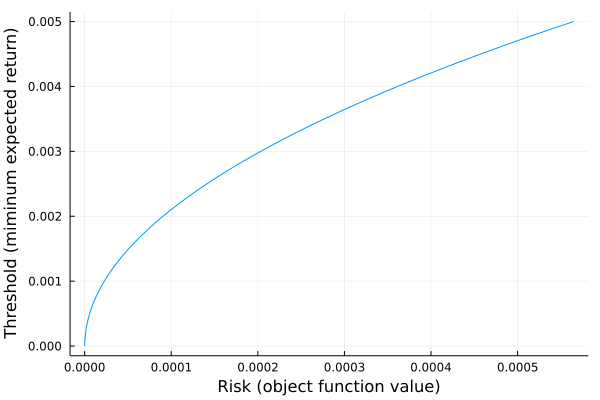

In [13]:
gr()
plot(risk_vector, threshold_vector, legend = false)
xlabel!("Risk (object function value)")
ylabel!("Threshold (miminum expected return)")